In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [18]:
def Hash(ratings):

    hash_userid={}
    hash_itemid={}
    count=0
    for i in sorted(set(ratings['UserId'].values)):
        hash_userid[i]=count
        count+=1
    count=0
    for i in sorted(set(ratings['ItemId'].values)):
        hash_itemid[i]=count
        count+=1
    return (hash_userid,hash_itemid)

In [19]:
def Test_index(train,test):
    
    hash_userid,hash_itemid=Hash(train)
    user_select=[]
    item_select=[]
    for i in set(test.index):
        user_select.append(hash_userid[i])
    for i in set(test['ItemId'].values):
        item_select.append(hash_itemid[i])
    return user_select,item_select

In [22]:
test=test.set_index('UserId')

In [23]:
user_select,item_select=Test_index(train,test)

In [24]:
def rmse(R,user,item,user_feature_matrix,item_feature_matrix,W):

    M=np.dot(user,item.T)
    temp_1=np.dot(user_feature_matrix,np.dot(W,item_feature_matrix.T))
    M=M+temp_1
    M[R==0]=0
    diff=R-M
    return np.sqrt(np.sum(np.power(diff,2))/len(R[R!=0]))

In [25]:
def update_item(row,item_row,user,R,item_feature_row,user_feature_matrix,W):

    temp_1=R[:,row]
    user=user[temp_1!=0]
    temp_2=temp_1[temp_1!=0]
    user_feature_row=user_feature_matrix[temp_1!=0]

    temp_3=np.dot(user,item_row.T)+np.dot(user_feature_row,np.dot(W,item_feature_row.T))-temp_2
    result=0
    for i in range(len(temp_3)):
        result+=user[i]*temp_3[i]
    return result/len(temp_3)

In [26]:
def update_user(row,user_row,item,R,user_feature_row,item_feature_matrix,W):

    temp_1=R[row]
    item=item[temp_1!=0]
    temp_2=temp_1[temp_1!=0]
    item_feature_row=item_feature_matrix[temp_1!=0]
    
    temp_3=np.dot(user_row,item.T)+np.dot(user_feature_row,np.dot(W,item_feature_row.T))-temp_2
    result=0
    for i in range(len(temp_3)):
        result+=item[i]*temp_3[i]
    return result/len(temp_3)

In [79]:
# running the model for testing on the test set
def model_implement_matrix_testing(R,user_feature_matrix,item_feature_matrix,user_select,item_select):     
    
    Lambda_1=0.01   #regulation 
    Lambda_2=0.01
    Lambda_3=0.01
    L=8   #Latent space      too much overfitting
    eTa=0.01  #gradient decent parameter     change to 0.001
    K=1000   #Iteration times
    
    train_rmse=[]
    #Latent matrix
    user=np.random.randn(user_feature_matrix.shape[0],L)/5
    item=np.random.randn(item_feature_matrix.shape[0],L)/5
    W=np.random.randn(user_feature_matrix.shape[1],item_feature_matrix.shape[1])/5
    
    for i in range(K):
        print(i)
        for row in range(len(user)):
            user[row]-=eTa*(update_user(row,user[row],item,R,user_feature_matrix[row],item_feature_matrix,W)+Lambda_1*user[row])
        for row in range(len(item)):
            item[row]-=eTa*(update_item(row,item[row],user,R,item_feature_matrix[row],user_feature_matrix,W)+Lambda_2*item[row])
        temp_1=np.dot(user,item.T)+np.dot(user_feature_matrix,np.dot(W,item_feature_matrix.T))
        temp_1[R==0]=0
        diff=temp_1-R
        result=0
        for x in range(len(user_feature_matrix)):
            for y in range(len(item_feature_matrix)):
                if diff[x][y]==0:
                    continue
                user_feature_row=user_feature_matrix[x].reshape(len(user_feature_matrix[x]),1)
                item_feature_row=item_feature_matrix[y].reshape(len(item_feature_matrix[y]),1)
                result+=diff[x][y]*np.dot(user_feature_row,item_feature_row.T)
        W-=eTa*(result/np.count_nonzero(R)+Lambda_3*W)
        
        train_rmse.append(rmse(R,user,item,user_feature_matrix,item_feature_matrix,W))
        
    return (user,item,W,train_rmse)

In [80]:
user,item,W,train_rmse=model_implement_matrix_testing(R,user_feature_matrix,item_feature_matrix,user_select,item_select)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
# K=1000
rmse(T,user[user_select],item[item_select],user_feature_matrix[user_select],item_feature_matrix[item_select],W)

0.5369394710299756

In [35]:
# K=400
rmse(T,user[user_select],item[item_select],user_feature_matrix[user_select],item_feature_matrix[item_select],W)

0.5443668956518897

In [38]:
def basic_rmse(R,user,item):

    M=np.dot(user,item.T)
    M[R==0]=0
    diff=R-M
    return np.sqrt(np.sum(np.power(diff,2))/len(R[R!=0]))

In [39]:
def basic_update_item(row,item_row,user,R,index):

    temp_1=R[:,row]
    user=user[index]
    temp_2=temp_1[index]

    temp_3=np.dot(user,item_row.T)-temp_2
    result=0
    for i in range(len(temp_3)):
        result+=user[i]*temp_3[i]
    return result/len(temp_3)

In [40]:
def basic_update_user(row,user_row,item,R,index):

    temp_1=R[row]
    item=item[index]
    temp_2=temp_1[index]
    
    temp_3=np.dot(user_row,item.T)-temp_2
    result=0
    for i in range(len(temp_3)):
        result+=item[i]*temp_3[i]
    return result/len(temp_3)

In [82]:
# basic model (without bilinear )
def basic_model(R):
    
    Lambda_1=0.01   #regulation 
    Lambda_2=0.01
    L=8   #Latent space      too much overfitting
    eTa=0.01  #gradient decent parameter     change to 0.001
    K=1000   #Iteration times
    
    train_rmse=[]
    #Latent matrix
    user=np.random.randn(user_feature_matrix.shape[0],L)/5
    item=np.random.randn(item_feature_matrix.shape[0],L)/5
    
    index_row=[]
    index_column=[]
    for row in R:
        index_row.append(list(np.where(row!=0)[0]))
    for col in range(R.shape[1]):
        index_column.append(list(np.where(R[:,col]!=0)[0]))    

    for i in range(K):
        print(i)
        for row in range(len(user)):
            user[row]-=eTa*(basic_update_user(row,user[row],item,R,index_row[row])+Lambda_1*user[row])
        for row in range(len(item)):
            item[row]-=eTa*(basic_update_item(row,item[row],user,R,index_column[row])+Lambda_2*item[row])
        
        train_rmse.append(basic_rmse(R,user,item))
        
    return (user,item,W,train_rmse)

In [83]:
basic_user,basic_item,basic_W,basic_train_rmse=basic_model(R)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [84]:
# K=1000
basic_rmse(T,basic_user[user_select],basic_item[item_select])

1.08846454082678

In [69]:
# K=1000
basic_rmse(T,basic_user[user_select],basic_item[item_select])

1.0902199663333647

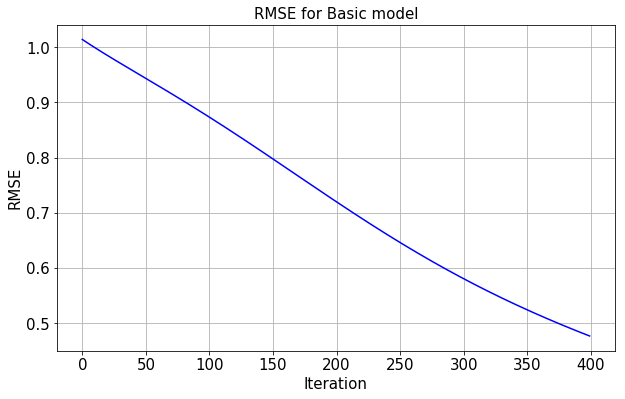

In [72]:
fig,ax=plt.subplots()
fig.set_size_inches(10,6)
plt.plot(basic_train_rmse,'b')

plt.title('RMSE for Basic model',fontsize=15)
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)
plt.show()
plt.close()

In [59]:
basic_rmse(T,basic_user[user_select],basic_item[item_select])

1.072060470158746

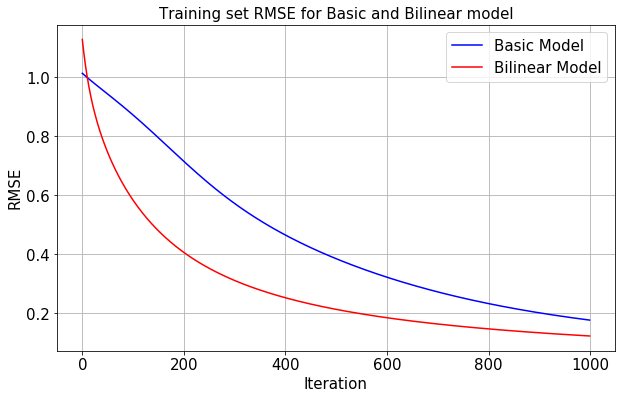

In [85]:
fig,ax=plt.subplots()
fig.set_size_inches(10,6)
plt.plot(basic_train_rmse,'b')
plt.plot(train_rmse,'r')
plt.title('Training set RMSE for Basic and Bilinear model',fontsize=15)
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('RMSE',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Basic Model','Bilinear Model'],fontsize=15)
plt.grid(True)
plt.show()
plt.close()

In [17]:
#rating matrix
R_dataframe = train.pivot(index = 'UserId', columns ='ItemId', values = 'Rating').fillna(0)
R=R_dataframe.values

#test matrix
test=test.reset_index()
test_dataframe = test.pivot(index = 'UserId', columns ='ItemId', values = 'Rating').fillna(0)
T=test_dataframe.values

user_feature_matrix=[]
for i in sorted(set(train['UserId'].values)):
    user_feature_matrix.append(list(user_feature_dict[i]))
item_feature_matrix=[]
for i in sorted(set(train['ItemId'].values)):
    item_feature_matrix.append(list(item_feature_dict[i]))

#feature matirx
user_feature_matrix=np.array(user_feature_matrix)
item_feature_matrix=np.array(item_feature_matrix)

In [8]:
ratings=pd.read_csv('/Users/apple/Documents/Project1_IOT_data/New_Model/ten_minutes/total/ratings_agg_nor.csv',index_col='Unnamed: 0')
ratings.head()

,UserId,ItemId,Rating,Timestamp
0,00:02:71:d3:0f:d3,1911015,1.179104,2015-09-04 23:05:22
1,00:02:71:d3:0f:d3,9807457,1.000000,2015-07-22 08:37:22
2,00:03:4d:a1:04:64,1090192,1.000000,2015-08-09 00:30:55
3,00:03:4d:a1:04:64,9000056,1.039801,2015-08-05 20:02:51
4,00:03:4d:a1:04:64,9000551,1.019900,2015-08-08 20:09:27


In [9]:
def User_Feature(ratings):
    
    feature=pd.read_csv('/Users/apple/Documents/Project1_IOT_data/New_Model/ten_minutes/total/feature/Feature_Vector.csv',index_col='Unnamed: 0')
    
    #only consider user in ratings
    ratings_user=set(list(ratings.UserId))
    feature=feature.loc[feature.UserId.map(lambda x: x in ratings_user)]
    
    #方差变标准差
    feature['genre23']=feature.genre23.map(lambda x:np.sqrt(x))     
    feature['genre24']=feature.genre24.map(lambda x:np.sqrt(x))
    feature['genre25']=feature.genre25.map(lambda x:np.sqrt(x))
    feature['genre26']=feature.genre26.map(lambda x:np.sqrt(x))
    feature['genre27']=feature.genre27.map(lambda x:np.sqrt(x))
    
    #genre0 平均停留时间
    feature=feature.sort_values(by='genre0')      
    feature['genre0']=Bin(feature['genre0'].values) 
    
    #genre1  总出现次数
    result=[]       
    for i in feature['genre1'].values:
        val=list(np.zeros(2))     # 2 is the number of features that turn into
        if i<=3:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre1']=result
    
    #genre2  周中出现次数
    result=[]       
    for i in feature['genre2'].values:
        val=list(np.zeros(2))
        if i<=3:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre2']=result
    
    #genre3   周末出现次数
    result=[]       
    for i in feature['genre3'].values:
        val=list(np.zeros(2))
        if i<=3:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre3']=result
    
    #genre4   交易次数
    result=[]       
    for i in feature['genre4'].values:
        val=list(np.zeros(2))
        if i==1:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre4']=result
    
    #genre5    最长停留时间
    feature=feature.sort_values(by='genre5')   
    feature['genre5']=Bin(feature['genre5'].values)
    
    #genre6    最短停留时间
    feature=feature.sort_values(by='genre6')   
    feature['genre6']=Bin(feature['genre6'].values)
    
    #genre  7,8,9,10  在时区1，2，3，4出现次数  genre 11,12,13,14  在时区1，2，3，4平均停留时间
    for i in range(7,15):     
        genre='genre%d'%i
        result=[]
        for j in feature[genre].values:
            val=list(np.zeros(2))
            if j==0:
                val[0]=1
                result.append(val)
            else:
                val[1]=1
                result.append(val)
        feature[genre]=result
    
    
    #15  购物平均停留时间 16  路过平均停留时间  17  mac平均停留时间与总时间之比   
    for i in range(15,18):   
        genre='genre%d'%i
        feature=feature.sort_values(by=genre)
        feature[genre]=Bin(feature[genre].values) 
    
    #genre  18  同一天出现多次的天数 19,20,21,22   第一，二，三，四周的出现次数 genre 23,24,25,26 在时区1，2，3，4的停留时间标准差
    for i in range(18,27):     
        genre='genre%d'%i
        result=[]
        for j in feature[genre].values:
            val=list(np.zeros(2))
            if j==0:
                val[0]=1
                result.append(val)
            else:
                val[1]=1
                result.append(val)
        feature[genre]=result
    
    #  27  停留时间标准差  
    genre='genre%d'%27
    feature=feature.sort_values(by=genre)
    feature[genre]=Bin(feature[genre].values) 
    
    #genre28   最后一次出现的时间
    result=[]       
    for i in feature['genre28'].values:
        val=list(np.zeros(2))
        if i<=28:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre28']=result
    
    #genre29  进店没有购物的次数
    result=[]       
    for i in feature['genre29'].values:
        val=list(np.zeros(2))
        if i==0:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre29']=result
    
    #genre20    路过次数
    result=[]       
    for i in feature['genre30'].values:
        val=list(np.zeros(2))
        if i<=5:
            val[0]=1
            result.append(val)
        else:
            val[1]=1
            result.append(val)
    feature['genre30']=result
    
    feature['feature']=feature.genre0
    del feature['genre0']
    for i in range(1,31):
        genre='genre%d'%i
        feature['feature']+=feature[genre]
        del feature[genre]
    
    feature=feature.reset_index()
    del feature['index']
    feature['feature']=feature.feature.map(lambda x:np.array(x))
    return feature

In [10]:
# for continuous user feature
def Bin(genre):
    
    length=len(genre)
    bins=np.array([0,genre[int(length/2)],genre[length-1]+1])
    output=[]
    
    place=np.digitize(genre,bins)
    for i in place:
        val=list(np.zeros(2))
        val[i-1]=1
        output.append(val)
    return output

In [11]:
user_feature=User_Feature(ratings)

In [12]:
def Item_Feature(ratings):
    
    sale=pd.read_csv('/Users/apple/Desktop/Data/ten_store/sale/Total_sale.csv',index_col='Unnamed: 0')
    sale['所属大品类代码']=sale['所属大品类代码'].astype('int')
    sale['商品代码']=sale['商品代码'].astype('int')
    #only consider the item in ratings
    ratings_item=set(list(ratings.ItemId))
    sale=sale.loc[sale['商品代码'].map(lambda x: x in ratings_item)]
    Hash={1:[1],2:[2,4,8,9],3:[5,6,10,12,15,17,18,30],4:[11,28],5:[13,20,21,22,23,24,25,26,27],6:[14,49,50,51,52,53,54,55,56,57],7:[16,60,66,80,98]}
    
    #category vector
    category={}
    count=0
    number=len(Hash)
    for i in sorted(Hash.keys()):
        category[i]=list(np.zeros(number))
        category[i][count]=1
        count+=1
    
    #price vector
    price={}
    for i in range(0,11):
        val=list(np.zeros(11))
        val[i]=1
        price[i]=val

    # connect 商品代码with 商品单价and 所属大品类代码
    var_1=dict(set(zip(sale['商品代码'],sale['商品单价'])))
    var_2=dict(set((zip(sale['商品代码'],sale['所属大品类代码']))))
    
    for new in Hash:
        for old in Hash[new]:
            for i in var_2:
                if var_2[i]==old:
                    var_2[i]=new
    
    item_price={}
    item_cat={}
    for i in set(sale['商品代码']):
        item_price[i]=interval(var_1[i],price)
        item_cat[i]=category[var_2[i]]
        
    output=[]
    for i in item_price:
        output.append([i,item_cat[i]+item_price[i]])
    output=pd.DataFrame(output,columns=['ItemId','feature'])
    output['feature']=output.feature.map(lambda x:np.array(x))
    return output

In [13]:
#set the price into 10 interval
def interval(p,price):
    
    #val=np.arange(0,110,10)
    val=[0,5,10,20]
    return price[np.digitize(p,val)-1]

In [14]:
item_feature=Item_Feature(ratings)

/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [15]:
def data_process(ratings,user,item):
    
    #ratings only contains the user and item showing in user_feature and item_feature
    var_user=set(list(user.UserId))
    var_item=set(list(item.ItemId))
    ratings=ratings.loc[ratings.UserId.map(lambda x: x in var_user)]
    ratings=ratings.loc[ratings.ItemId.map(lambda x: x in var_item)]
    
    #user_feature and item_feature only contains the user and item showing in ratings
    temp_user=set(list(ratings.UserId))
    temp_item=set(list(ratings.ItemId))
    user=user.loc[user.UserId.map(lambda x: x in temp_user)]
    item=item.loc[item.ItemId.map(lambda x: x in temp_item)]
    
    train=ratings.sample(int(0.8*len(ratings)))
    test=ratings.loc[list(set(ratings.index)-set(train.index))]    
    users_train=set(list(train.UserId))
    items_train=set(list(train.ItemId))
    test=test.loc[test.UserId.map(lambda x: x in users_train)]
    test=test.loc[test.ItemId.map(lambda x: x in items_train)]

    print(ratings.shape)
    print(train.shape)
    print(test.shape)
    test=test.set_index('UserId')
    user=user.set_index('UserId')
    item=item.set_index('ItemId')
    
    user_feature_dict={}
    item_feature_dict={}
    user_dim=0
    item_dim=0
    for i in user.index:
        user_feature_dict[i]=user.loc[i]['feature']
        user_dim=len(user_feature_dict[i])
    for i in item.index:
        item_feature_dict[i]=item.loc[i]['feature']
        item_dim=len(item_feature_dict[i])
    
    return [train,test,user_feature_dict,item_feature_dict,user_dim,item_dim]

In [16]:
train,test,user_feature_dict,item_feature_dict,user_dim,item_dim=data_process(ratings,user_feature,item_feature)

(44917, 4)
(35933, 4)
(7137, 4)


In [89]:
def painting(W,f1,f2):
    
    g=f1/2
    fig,ax=plt.subplots()
    fig.set_size_inches(10,6)
    index=np.arange(0,2*len(new_item_code_word),2)
    bar_with=0.8
    pic=plt.bar(index,W[f1][:7],bar_with,alpha=0.6,color='r')
    pic=plt.bar(index+bar_with,W[f2][:7],bar_with,alpha=0.6,color='b')
    
    plt.legend(labels=['First Half','Second Half'],fontsize=15)
    plt.xticks(index,list(new_item_code_word.values()),rotation=-20,fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('genre%d'%g,fontsize=15)
    ax.set_xlabel('Items',fontsize=15)
    ax.set_ylabel('Percentage',fontsize=15)
    plt.show()
    plt.close()

In [90]:
new_item_code_word={1:'Cigarette',2:'Snack',3:'Food',4:'Alcohol',5:'Beverage',6:'Daily Use',7:'Spiritual Needs'}

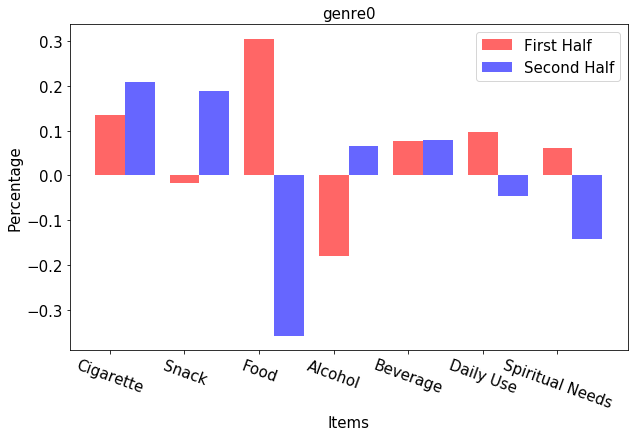

In [92]:
painting(W,0,1)